In [72]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [73]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

# from functions import func_conv_data

In [74]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

In [75]:
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    return ds

def get_dataset(col, var, freq, expe, model, grid):
    dataset = col.search(variable_id = var, table_id = freq, experiment_id = expe, 
                         source_id = model, grid_label = grid).to_dataset_dict(
        zarr_kwargs= {'consolidated': True, 'decode_times':True}, preprocess = rename_coords)
    dataset = dataset[list(dataset)[0]].squeeze('member_id').reset_coords('member_id', drop = True)
    return dataset

In [76]:
model_name = 'GFDL-CM4' 
experiment = 'piControl'
frequency = 'Omon'
variables = ['so', 'thetao', 'tos']

In [77]:
dataset_gr = get_dataset(col, variables, frequency, experiment, model_name, 'gr')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [78]:
ds_tas = get_dataset(col, 'tas', 'Amon', experiment, model_name, 'gr1')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [79]:
# functions modified from Convection.ipynb

def func_regrid(ds, ds_out, gr_method = 'bilinear', reuse = False, clear = True):
    dsr = xe.Regridder(ds, ds_out, gr_method, periodic = True, reuse_weights = reuse, ignore_degenerate = True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    if clear:
        dsr.clean_weight_file()
    return dsr_out

def sel_time(ds, start_year, end_year, month = None):
    ds = ds.isel(time = slice((start_year-1)*12, end_year*12))
    if month:
        ds = list(ds.groupby("time.month"))[month-1][-1]
    return ds

def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

def func_mld(dens_diff, depths):
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        nthr_index = np.where(dens_diff > 0)[0]
        if len(nthr_index) == 0:
            naninds = np.where(np.isnan(dens_diff))[0]
            if len(naninds) > 0:
                nanindex = naninds[0]
            else:
                nanindex = len(depths)
            mld = depths[nanindex-1]
        else:
            nind = nthr_index[0] + 1
            mld = np.interp(0, dens_diff[:nind], depths[:nind])
    return mld

def xr_func_mld(dens):
    dens10 = dens.interp(lev = 10, method = 'linear')  # density at 10m
    dens_diff = dens - dens10 - 0.03               # density differences 
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff.chunk({"time":25, "lat":45, "lon":45}),  
        dens_diff.lev, 
        input_core_dims = [["lev"], ["lev"]], 
        vectorize = True,
        dask = "parallelized",
        output_dtypes = [dens_diff.lev.dtype])
    return mld

def select_conv_area_data(ds, conv_area):
    ds = ds.copy()
    ds = ds.where(conv_area > 0)
    ds = ds.groupby('time.year').mean(dim = 'time', skipna = True)
    ds = ds.mean(dim = 'lat', skipna = True).mean(dim = 'lon', skipna = True)
    return ds

def select_region(ds, region, reg_dict):
    return ds.sel(lon = reg_dict[region]['lon'], lat = reg_dict[region]['lat'], method="nearest")

def add_region_attrs(ds, region, reg_dict):
    ds.attrs['region_name'] = reg_dict[region]['name']
    ds.attrs['conv_index'] = reg_dict[region]['convind']
    ds.attrs['rep_lon'] = reg_dict[region]['rlon']
    ds.attrs['rep_lat'] = reg_dict[region]['rlat']
    return ds

def func_conv_data(dataset, region, start_year, end_year, reg_dict, month_no = 9, regrid = None):
    da_t = sel_time(dataset.thetao, start_year, end_year)
    da_s = sel_time(dataset.so, start_year, end_year)
    da_dens = sel_time(dens0(da_s, da_t), start_year, end_year, month = month_no)
    if not regrid == None:
        da_dens = func_regrid(da_dens, regrid)
        da_t = func_regrid(da_t, regrid)
        da_s = func_regrid(da_s, regrid)
    da_dens = select_region(da_dens, region, reg_dict = reg_dict)
    da_t = select_region(da_t, region, reg_dict = reg_dict)
    da_s = select_region(da_s, region, reg_dict = reg_dict)
    da_mld = xr_func_mld(da_dens)
    conv = xr.where(da_mld >= reg_dict[region]['convdepth'], da_mld, np.nan)
    conv_area = conv.mean(dim = 'time', skipna = True)
    da_t_conv = select_conv_area_data(da_t, conv_area)
    da_s_conv = select_conv_area_data(da_s, conv_area)
    conv_area = add_region_attrs(conv_area, region, reg_dict)
    da_t_conv = add_region_attrs(da_t_conv, region, reg_dict)
    da_s_conv = add_region_attrs(da_s_conv, region, reg_dict)
    ind_t = da_t_conv.interp(lev = da_t_conv.conv_index)
    conv_ind = -1 * (ind_t - ind_t.mean('year'))/ind_t.std('year')
    return conv_area, da_t_conv, da_s_conv, conv_ind

In [80]:
region_dict = {
    'ws':{'name':'Weddell Sea', # Weddell Sea [60W-30E, 90S-50S]
          'lon':np.concatenate((np.arange(300.1,360.1), np.arange(0.1,31.1))),
          'lat':np.arange(-90,-49),
          'rlon':345, # representative lon lat
          'rlat':-70,
          'convdepth':2000,  # mld >= 2000 as conv area
          'convind':2000},  # conv index -- temp at 1500m 
    'rs':{'name':'Ross Sea', # Ross Sea [160W-130E, 90S-50S]
          'lon':np.arange(160.1, 231.1),
          'lat':np.arange(-90,-49),
          'rlon':195,
          'rlat':-70,
          'convdepth':2000,
          'convind':500}, 
    'rs2':{'name':'Ross Sea', # Ross Sea with convindex = temp at 2000m
           'lon':np.arange(160.1, 231.1),
           'lat':np.arange(-90,-49),
           'rlon':195,
           'rlat':-70,
           'convdepth':2000,
           'convind':2000}, 
}  

In [81]:
start_year = 1
end_year = 500

In [82]:
__, __, __, conv_ind_ws = func_conv_data(dataset_gr, 'ws', start_year, end_year, region_dict)
__, __, __, conv_ind_rs = func_conv_data(dataset_gr, 'rs', start_year, end_year, region_dict)
__, __, __, conv_ind_rs2 = func_conv_data(dataset_gr, 'rs2', start_year, end_year, region_dict)

In [83]:
def func_composite(da, dind):
    da = da.groupby("time.year").mean(dim = 'time', skipna = True)
    comp_da = da.where(dind<-0.5).mean(dim='year',skipna = True) - da.where(dind>0.5).mean(dim='year',skipna = True)
    return comp_da

In [84]:
composite_seasurf_temp_ws = func_composite(dataset_gr.tos, conv_ind_ws)
composite_airsurf_temp_ws = func_composite(ds_tas.tas, conv_ind_ws)

In [85]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

options.worker_cores = 16 #16 / 4
options.worker_memory = 32 #32 / 8  

cluster = gateway.new_cluster(options)
cluster.adapt(minimum = 0, maximum = 120)

client = cluster.get_client() 
cluster

In [86]:
composite_seasurf_temp_ws = composite_seasurf_temp_ws.load()
composite_airsurf_temp_ws = composite_airsurf_temp_ws.load()

In [87]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Text(0.5, 1.0, 'Sea Surface temperature composites - Weddell, year 1 - 500, GFDL-CM4')

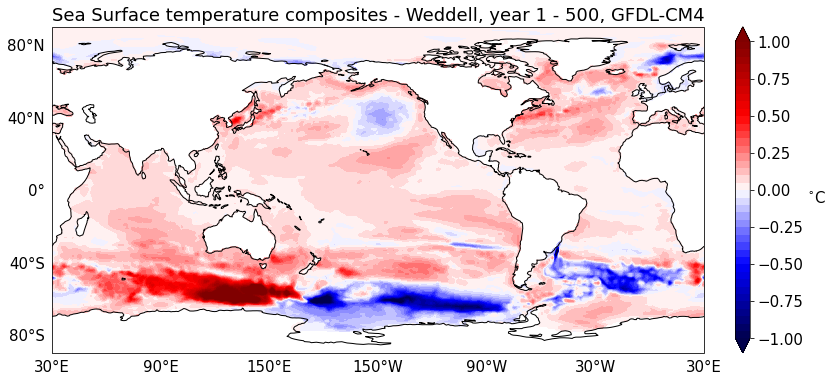

In [88]:
pltdata = composite_seasurf_temp_ws
conv_region_name = 'Weddell'

fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
# ax.set_extent([30, 390, -85, 85], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)


ax.set_xticks([30, 90, 150, 210, 270, 330, 29.999999], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-80, 120, 40), crs=ccrs.PlateCarree())
ax.set_global()
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.tick_params(labelsize = 15)
# gl = ax.gridlines(draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False
# gl.xlines = False
# gl.ylines = False
# gl.ylocator = mticker.FixedLocator([-80, -40, 0, 40, 80])
# gl.xlocator = mticker.FixedLocator([-150, -90, -30, 30, 90, 150])
# # gl.ylocator = LatitudeLocator()
# # gl.xformatter = LongitudeFormatter()
# # gl.yformatter = LatitudeFormatter()
# gl.xlabel_style = {'size': 15}
# gl.ylabel_style = {'size': 15}

my_level = np.linspace(-1, 1, 41)
pltdata_new, pltlon = add_cyclic_point(pltdata, coord=pltdata.lon)
im = ax.contourf(pltlon, pltdata.lat, pltdata_new, 
                 transform=ccrs.PlateCarree(), cmap = plt.cm.seismic, levels = my_level, extend = 'both')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('$^{\circ}$C', fontsize=15, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Sea Surface temperature composites - {}, year {} - {}, {}'.format(
    conv_region_name, start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Sea Surface air temperature composites - Weddell, year 1 - 500, GFDL-CM4')

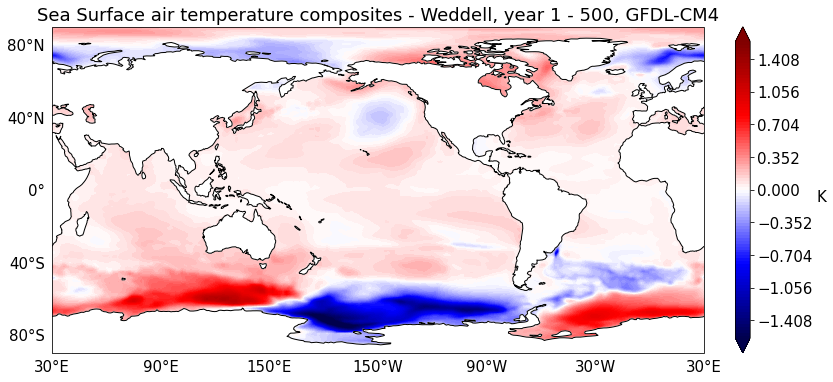

In [89]:
pltdata = composite_airsurf_temp_ws
conv_region_name = 'Weddell'

fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))

ax.add_feature(cfeature.LAND, zorder=1, color='w')
ax.add_feature(cfeature.COASTLINE)

ax.set_xticks([30, 90, 150, 210, 270, 330, 29.999999], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-80, 120, 40), crs=ccrs.PlateCarree())
ax.set_global()
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.tick_params(labelsize = 15)
# gl = ax.gridlines(xlocs = np.arange(-330, 330, 60), draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False
# gl.xlines = False
# gl.ylines = False
# gl.ylocator = mticker.FixedLocator([-80, -40, 0, 40, 80])
# # gl.ylocator = LatitudeLocator()
# # gl.xformatter = LongitudeFormatter()
# # gl.yformatter = LatitudeFormatter()
# gl.xlabel_style = {'size': 15}
# gl.ylabel_style = {'size': 15}

my_level = np.linspace(-1.6, 1.6, 101)
pltdata_new, pltlon = add_cyclic_point(pltdata, coord=pltdata.lon)
im = ax.contourf(pltlon, pltdata.lat, pltdata_new, 
                 transform=ccrs.PlateCarree(), cmap = plt.cm.seismic, levels = my_level, extend = 'both')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('K', fontsize=15, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Sea Surface air temperature composites - {}, year {} - {}, {}'.format(
    conv_region_name, start_year, end_year, model_name), fontsize=18)

In [91]:
client.close()
cluster.close()